In [1]:
import os
import torch
import random
import numpy as np
from loguru import logger
from torch.utils.data import DataLoader
from torch import nn

from pose.dataset import pose_dataset
from pose.utils import (
    collate_fn,
    geodesic_distance,
    relative_pose_error,
    relative_pose_error_np,
    recall_object
)
from pose.model import Mkpts_Reg_Model
from pose.animator import Animator


if os.name == 'nt':
    LM_dataset_path = 'd:/git_project/POPE/data/LM_dataset/'
    LM_dataset_json_path = 'd:/git_project/POPE/data/pairs/LINEMOD-test.json'
    LM_dataset_points_path = 'd:/git_project/POPE/data/LM_dataset-points/'

    onepose_path = 'e:/datasets/OnePose/test_data/'
    onepose_json_path = 'd:/git_project/POPE/data/pairs/Onepose-test.json'
    onepose_points_path = 'd:/git_project/POPE/data/onepose-points/'

    oneposeplusplus_path = 'e:/datasets/OnePose++/lowtexture_test_data/'
    oneposeplusplus_json_path = 'd:/git_project/POPE/data/pairs/OneposePlusPlus-test.json'
    oneposeplusplus_points_path = 'd:/git_project/POPE/data/oneposeplusplus-points/'
elif os.name == 'posix':
    LM_dataset_path = 'data/LM_dataset/'
    LM_dataset_json_path = 'data/pairs/LINEMOD-test.json'
    LM_dataset_points_path = 'data/LM_dataset-points/'

    onepose_path = 'data/onepose/'
    onepose_json_path = 'data/pairs/Onepose-test.json'
    onepose_points_path = 'data/onepose-points/'

    oneposeplusplus_path = 'data/oneposeplusplus/'
    oneposeplusplus_json_path = 'data/pairs/OneposePlusPlus-test.json'
    oneposeplusplus_points_path = 'data/oneposeplusplus-points/'

paths = [
    # ('linemod', LM_dataset_path, LM_dataset_json_path, LM_dataset_points_path),
    ('onepose', onepose_path, onepose_json_path, onepose_points_path),
    # ('oneposeplusplus', oneposeplusplus_path, oneposeplusplus_json_path, oneposeplusplus_points_path),
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = pose_dataset(paths)
mkpts_max_len, mkpts_sum_len = dataset.get_mkpts_info()

  0%|          | 0/10 [00:00<?, ?it/s]

d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\566.png-581.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\544.png-557.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\562.png-621.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\620.png-562.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\579.png-561.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\564.png-543.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\607.png-553.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\601.png-549.png.txt does not exist
d:/git_project/POPE/data/onepose-points/0409-aptamil-box\mkpts0\606.png-547.png.txt does not exist


100%|██████████| 10/10 [01:59<00:00, 11.94s/it]


In [2]:
random.seed(20231223)
torch.manual_seed(20231223)
torch.cuda.manual_seed(20231223)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [3]:
num_sample = 500
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_fn(num_sample))
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_fn(num_sample))

In [4]:
net = torch.load('./weights/linemod-relative_r-gt_t-6d-500-2024-01-08-13-02-42-1.6629.pth').to(device)

net.eval()

Mkpts_Reg_Model(
  (embedding): Embedding()
  (transformerlayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=76, out_features=76, bias=True)
    )
    (linear1): Linear(in_features=76, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=76, bias=True)
    (norm1): LayerNorm((76,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((76,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=76, out_features=76, bias=True)
        )
        (linear1): Linear(in_features=76, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inp

In [5]:
id2name_dict = {
    1: "ape",
    2: "benchvise",
    4: "camera",
    5: "can",
    6: "cat",
    8: "driller",
    9: "duck",
    10: "eggbox",
    11: "glue",
    12: "holepuncher",
    13: "iron",
    14: "lamp",
    15: "phone",
}

In [6]:
# linemod
ape_data = []
benchvise_data = []
camera_data = []
can_data = []
cat_data = []
driller_data = []
duck_data = []
eggbox_data = []
glue_data = []
holepuncher_data = []
iron_data = []
lamp_data = []
phone_data = []
# onepose
aptamil_data = []
jzhg_data = []
minipuff_data = []
hlyormosiapie_data = []
brownhouse_data = []
oreo_data = []
mfmilkcake_data = []
diycookies_data = []
taipingcookies_data = []
tee_data = []
# onepose++
toyrobot_data = []
yellowduck_data = []
sheep_data = []
fakebanana_data = []
teabox_data = []
orange_data = []
greenteapot_data = []
lecreusetcup_data = []
insta_data = []

all_data = {
    # linemod
    'ape_data': ape_data,
    'benchvise_data': benchvise_data,
    'camera_data': camera_data,
    'can_data': can_data,
    'cat_data': cat_data,
    'driller_data': driller_data,
    'duck_data': duck_data,
    'eggbox_data': eggbox_data,
    'glue_data': glue_data,
    'holepuncher_data': holepuncher_data,
    'iron_data': iron_data,
    'lamp_data': lamp_data,
    'phone_data': phone_data,
    # onepose
    'aptamil_data': aptamil_data,
    'jzhg_data': jzhg_data,
    'minipuff_data': minipuff_data,
    'hlyormosiapie_data': hlyormosiapie_data,
    'brownhouse_data': brownhouse_data,
    'oreo_data': oreo_data,
    'mfmilkcake_data': mfmilkcake_data,
    'diycookies_data': diycookies_data,
    'taipingcookies_data': taipingcookies_data,
    'tee_data': tee_data,
    # onepose++
    'toyrobot_data': toyrobot_data,
    'yellowduck_data': yellowduck_data,
    'sheep_data': sheep_data,
    'fakebanana_data': fakebanana_data,
    'teabox_data': teabox_data,
    'orange_data': orange_data,
    'greenteapot_data': greenteapot_data,
    'lecreusetcup_data': lecreusetcup_data,
    'insta_data': insta_data,
}

In [7]:
linemod_type = ['ape_data', 'benchvise_data', 'camera_data', 'can_data', 'cat_data', 'driller_data', 'duck_data', 'eggbox_data', 'glue_data', 'holepuncher_data', 'iron_data', 'lamp_data', 'phone_data']
onepose_type = ['aptamil_data', 'jzhg_data', 'minipuff_data', 'hlyormosiapie_data', 'brownhouse_data', 'oreo_data', 'mfmilkcake_data', 'diycookies_data', 'taipingcookies_data', 'tee_data']
oneposeplusplus_type = ['toyrobot_data', 'yellowduck_data', 'sheep_data', 'fakebanana_data', 'teabox_data', 'orange_data', 'greenteapot_data', 'lecreusetcup_data', 'insta_data']

In [8]:
for i, batch in enumerate(test_dataloader):
    for data in batch:
        if 'lm' in data['name']:
            all_data[f"{id2name_dict[int(data['name'][2:])]}_data"].append(data)
        else:
            all_data[f"{data['name']}_data"].append(data)

empty_keys = []
for key in all_data.keys():
    if len(all_data[key]) == 0:
        empty_keys.append(key)

for key in empty_keys:
    all_data.pop(key)

for key in all_data.keys():
    print(key, len(all_data[key]))

print('len(all_data):', len(all_data))

aptamil_data 77
jzhg_data 73
minipuff_data 41
hlyormosiapie_data 59
brownhouse_data 55
oreo_data 55
mfmilkcake_data 59
diycookies_data 68
taipingcookies_data 56
tee_data 89
len(all_data): 10


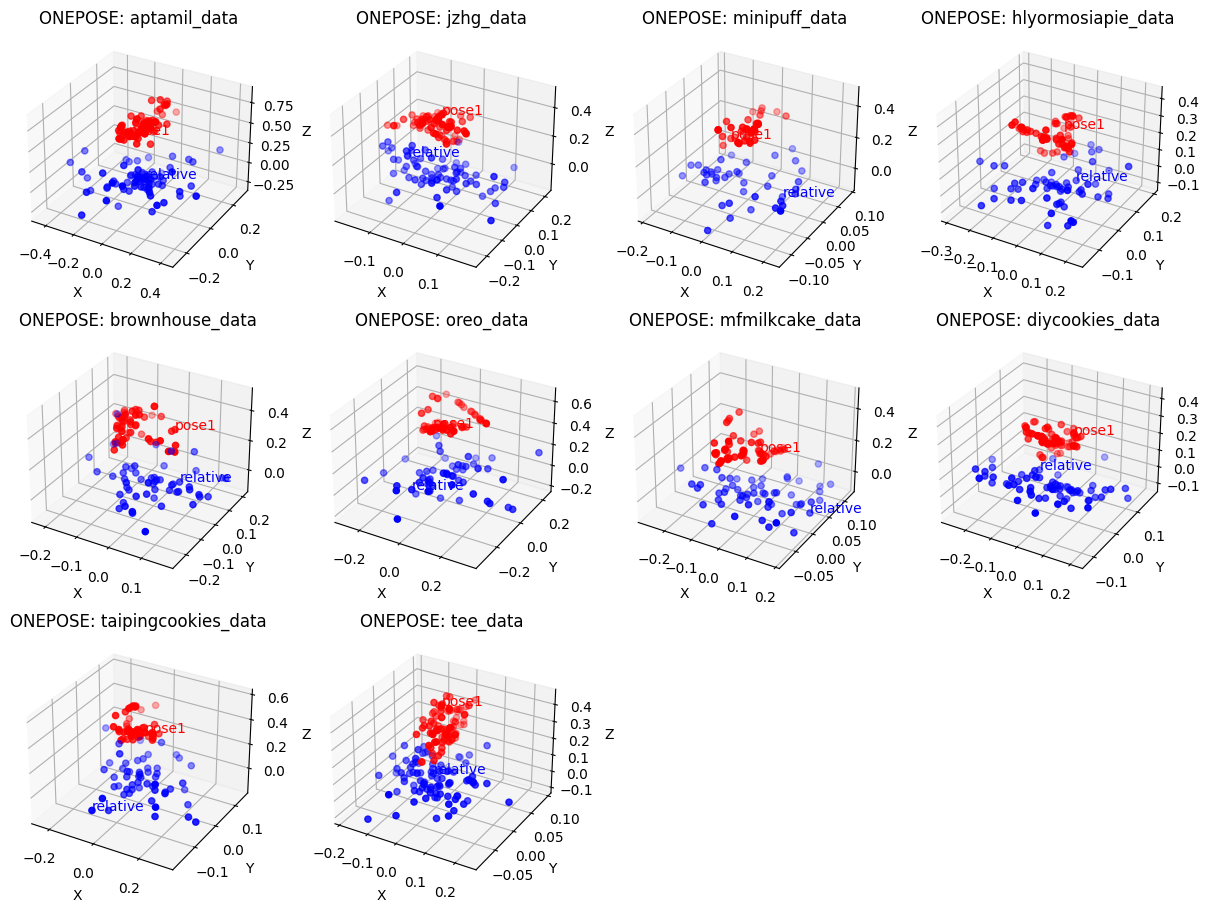

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))

for i, key in enumerate(all_data.keys()):
    pose1_t_x = []
    pose1_t_y = []
    pose1_t_z = []
    relative_t_x = []
    relative_t_y = []
    relative_t_z = []

    for item in all_data[key]:
        K0 = item['K0']
        K1 = item['K1']
        pose0 = item['pose0']
        pose1 = item['pose1']
        pre_bbox = item['pre_bbox']
        gt_bbox = item['gt_bbox']
        mkpts0 = item['mkpts0']
        mkpts1 = item['mkpts1']
        pre_K = item['pre_K']
        name = item['name']
        pair_name = item['pair_name']

        pose1_t_x.append(pose1[0, 3])
        pose1_t_y.append(pose1[1, 3])
        pose1_t_z.append(pose1[2, 3])

        relative_pose = np.matmul(pose1, np.linalg.inv(pose0))
        relative_t_x.append(relative_pose[0, 3])
        relative_t_y.append(relative_pose[1, 3])
        relative_t_z.append(relative_pose[2, 3])

    ax = fig.add_subplot(4, 4, 1 + i, projection='3d')
    if key in linemod_type:
        ax.set_title(f"LINEMOD: {key}")
    elif key in onepose_type:
        ax.set_title(f"ONEPOSE: {key}")
    elif key in oneposeplusplus_type:
        ax.set_title(f"ONEPOSE++: {key}")

    ax.scatter(pose1_t_x, pose1_t_y, pose1_t_z, c='r')
    ax.scatter(relative_t_x, relative_t_y, relative_t_z, c='b')

    ax.text(pose1_t_x[0], pose1_t_y[0], pose1_t_z[0], 'pose1', c='r')
    ax.text(relative_t_x[0], relative_t_y[0], relative_t_z[0], 'relative', c='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.show()